In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from keras.preprocessing.image import ImageDataGenerator
import multiprocessing

2023-05-19 15:01:21.567982: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-19 15:01:21.662441: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-19 15:01:21.664057: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 15:01:22.857194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define the path to the data directory

data_dir_tcoil = "/media/DATA/tcoil/close_vision/"

# Define the paths to the train and test directories
train_dir_tcoil = os.path.join(data_dir_tcoil , "train")
val_dir_tcoil  = os.path.join(data_dir_tcoil , "val")
test_dir_tcoil  = os.path.join(data_dir_tcoil , "test")

# Define the input image size and number of classes
img_width = 224
img_height = 224
batch_size = 8

In [3]:
def visualize_data(data_dir):
    class_counts = []
    labels = []
    colors = ['red', 'green']  # Add more colors as needed

    for folder in os.listdir(data_dir):
        labels.append(folder)
        class_count = len(os.listdir(os.path.join(data_dir, folder)))
        class_counts.append(class_count)

    x = np.arange(len(labels))
    width = 0.5

    fig, ax = plt.subplots(figsize=(12, 8))
    rects = ax.bar(x, class_counts, width, color=colors)

    ax.set_ylabel('Number of Images')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects)

    fig.tight_layout()
    plt.show()

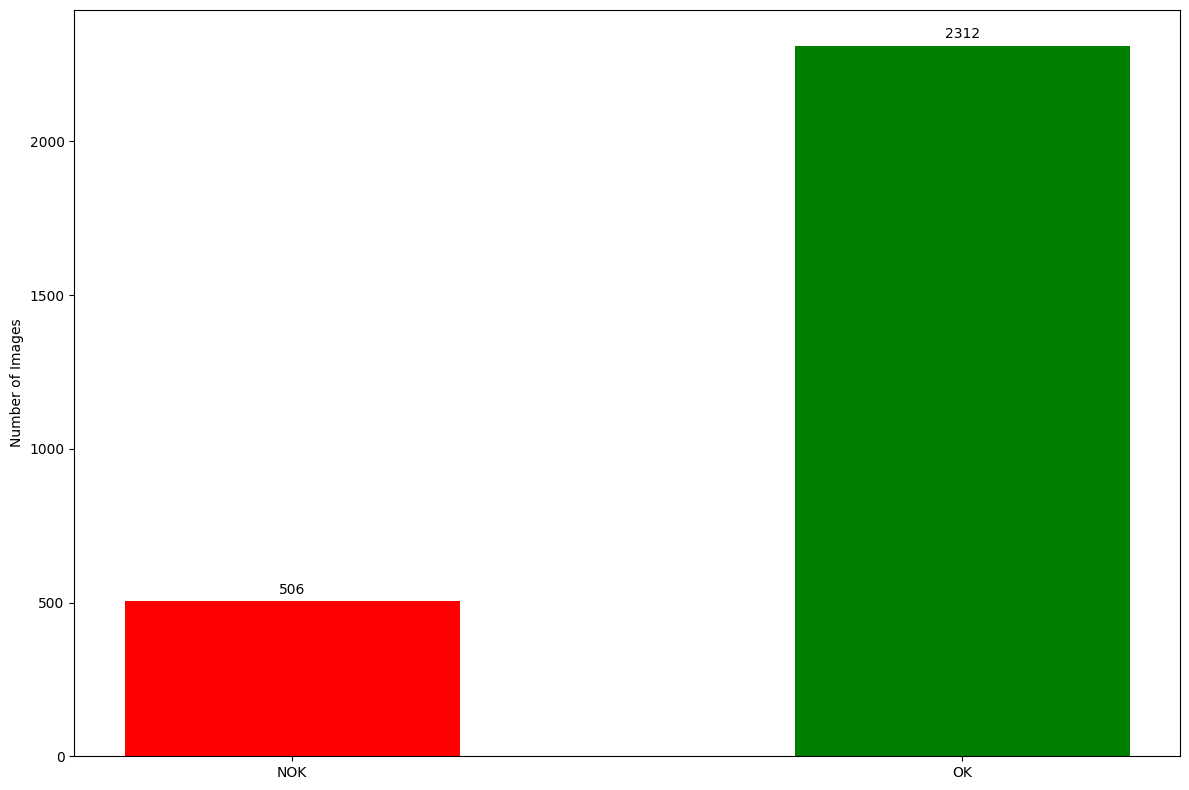

In [4]:
visualize_data("/media/DATA/tcoil-unorg/close_vision")

In [5]:
def visualize_data(train_dir, val_dir, test_dir):
    train_counts = []
    val_counts = []
    test_counts = []
    labels = []

    for folder in os.listdir(train_dir):
        labels.append(folder)
        train_counts.append(len(os.listdir(os.path.join(train_dir, folder))))

    for folder in os.listdir(val_dir):
        val_counts.append(len(os.listdir(os.path.join(val_dir, folder))))

    for folder in os.listdir(test_dir):
        test_counts.append(len(os.listdir(os.path.join(test_dir, folder))))

    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 8))
    rects1 = ax.bar(x - width, train_counts, width, label='Train')
    rects2 = ax.bar(x, val_counts, width, label='Validation')
    rects3 = ax.bar(x + width, test_counts, width, label='Test')

    ax.set_ylabel('Number of Images')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.show()


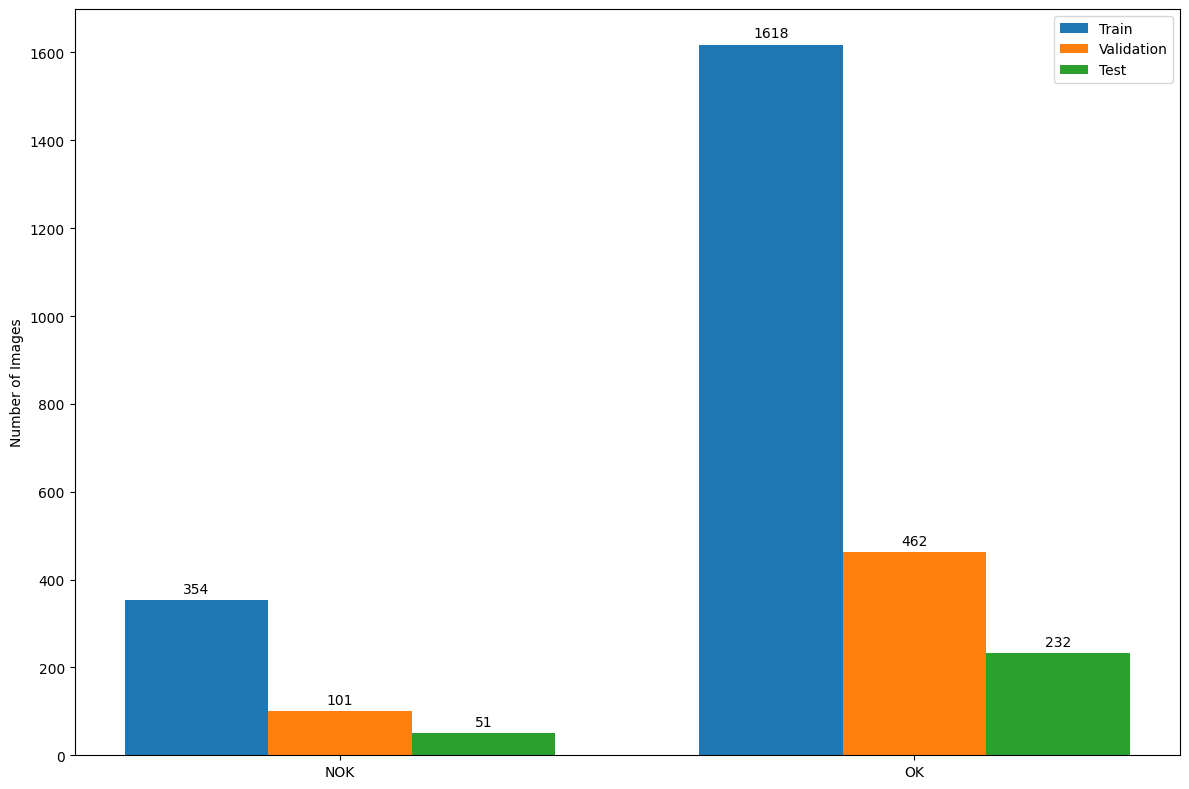

In [6]:
visualize_data(train_dir_tcoil, val_dir_tcoil, test_dir_tcoil)

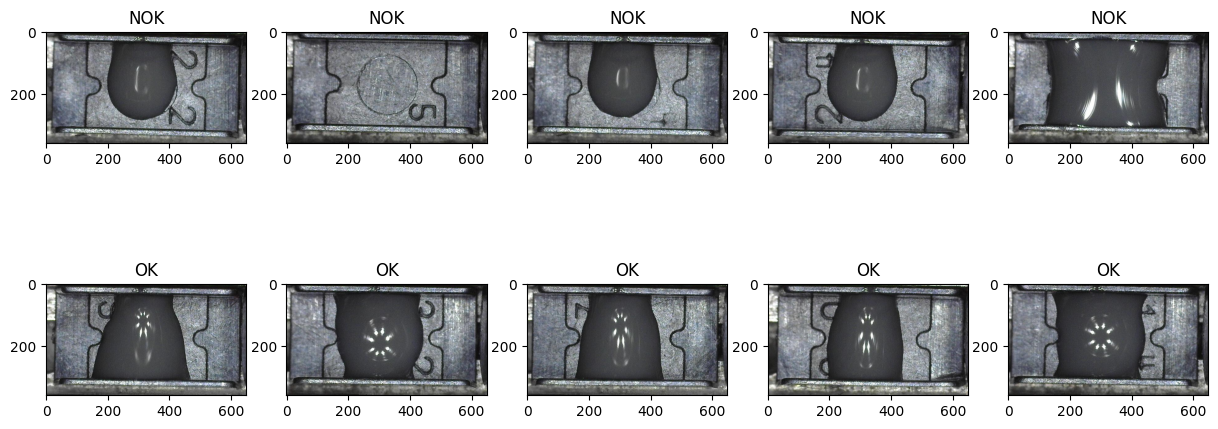

In [7]:
# Define the paths to the train directories for the "fail" and "pass" classes
fail_train_dir = os.path.join(data_dir_tcoil, "train", "NOK")
pass_train_dir = os.path.join(data_dir_tcoil, "train", "OK")

# Define the paths to a few images from each class
fail_images = [os.path.join(fail_train_dir, f) for f in os.listdir(fail_train_dir)[:5]]
pass_images = [os.path.join(pass_train_dir, f) for f in os.listdir(pass_train_dir)[:5]]

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i, image_path in enumerate(fail_images):
    ax = axes[0, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("NOK")

for i, image_path in enumerate(pass_images):
    ax = axes[1, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("OK")

plt.show()

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
    fill_mode='nearest'
)

train_data = train_datagen.flow_from_directory(
    train_dir_tcoil,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    seed=42,
    shuffle=True
    )

Found 1972 images belonging to 2 classes.


In [9]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_data = val_datagen.flow_from_directory(
    val_dir_tcoil,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    seed=42,
    shuffle=True
    )

Found 563 images belonging to 2 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    test_dir_tcoil,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    shuffle = False,
    seed=42
    )

Found 283 images belonging to 2 classes.


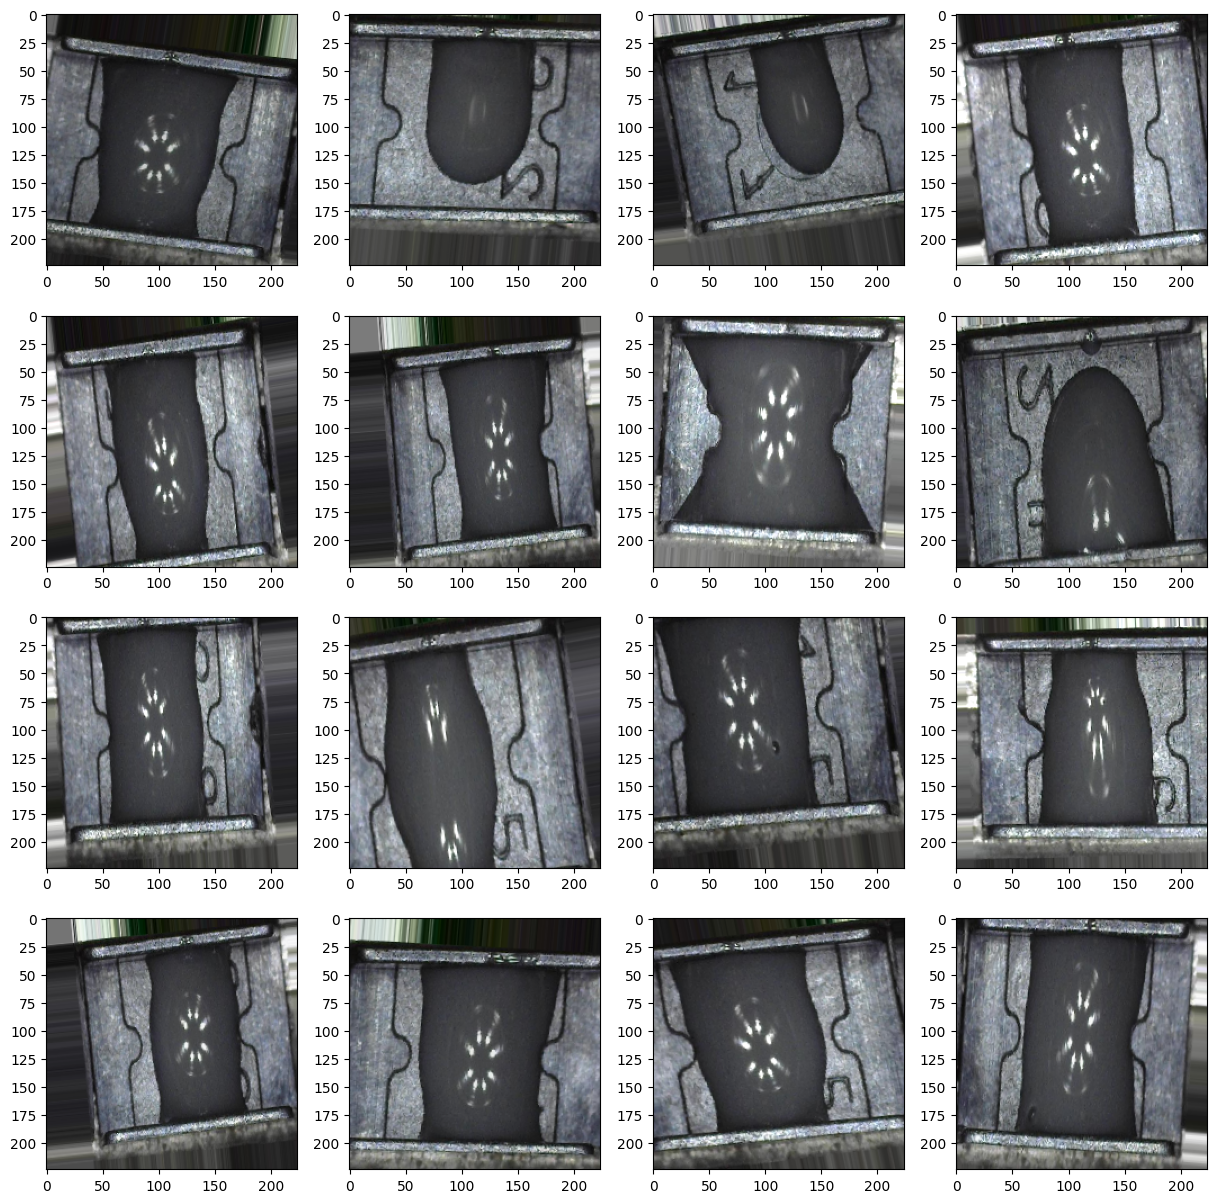

In [12]:
# Get a batch of images from the generator
img_batch, _ = train_data.next()

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_batch[i])
    ax.axis('on')
    
plt.show()

In [13]:
class_names = train_data.class_indices
class_names

{'NOK': 0, 'OK': 1}

In [14]:
# Get the class labels from the data generator
labels = train_data.classes

# Calculate the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=labels)

# Convert the class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

In [15]:
class_weight_dict

{0: 2.785310734463277, 1: 0.6093943139678616}